In [5]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score

In [4]:
!pip install -qq tqdm

In [3]:
!pip -qq install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.5

In [2]:
!pip -qq install catboost xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 1.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#model paths
kbert="/content/drive/MyDrive/Capstone/Models/Kannada/kbert_kannada.sav"
xlm="/content/drive/MyDrive/Capstone/Models/Kannada/xlm_roberta_kannada.sav"
distilbert="/content/drive/MyDrive/Capstone/Models/Kannada/distilbert_kannada.sav"
muril="/content/drive/MyDrive/Capstone/Models/Kannada/muril_kannada.sav"
mbert="/content/drive/MyDrive/Capstone/Models/Kannada/mbert_kannada.sav"

In [7]:
import pickle
kbert_model=pickle.load(open(kbert,'rb'))
xlm_model=pickle.load(open(xlm,'rb'))
mbert_model=pickle.load(open(mbert,'rb'))
distilbert_model=pickle.load(open(distilbert,'rb'))
muril_model=pickle.load(open(muril,'rb'))

In [8]:
colab_sample_data_path = '/content/sample_data'
os.chdir(colab_sample_data_path)

## Preprocessing the dataset (text to numerical feature vector)

In [9]:
from IPython.display import clear_output
from tqdm import tqdm
import pandas as pd

def preprocess_dataset(df, model, training, batch_size):
    processed_text, labels = [], []

    #n=df[df.columns[0]].count()

    #if training:
    #  df = df.head(int(n * 0.70))
    #else:
    #  df = df.tail(int(n * 0.30))

    # Use tqdm for a progress bar
    total_batches = (len(df) + batch_size - 1) // batch_size
    for i in tqdm(range(0, len(df), batch_size), total=total_batches, desc="Processing Data"):
        batch_texts = df['text'].iloc[i:i+batch_size].tolist()
        batch_labels = df['label'].iloc[i:i+batch_size].tolist()

        # Use batch processing for predictions
        batch_predictions = model.predict(batch_texts)
        processed_text.extend(batch_predictions[1])  # processed text
        labels.extend(batch_labels)

        clear_output(wait=True)

    return np.array(processed_text), np.array(labels)


In [10]:
dataset2=pd.read_csv("/content/drive/MyDrive/Capstone/Dataset/Preprocessed/kannada_dataset_2_train.csv")
dataset2_filtered = dataset2[dataset2['label'] != 2]
X=list(dataset2_filtered['text'])
y=list(dataset2_filtered['label'])
X_tr, X_te, y_tr, y_te = train_test_split(X, y , random_state=42,test_size=0.2)
train_df = pd.DataFrame({"text": X_tr, "label": y_tr})
test_df = pd.DataFrame({"text": X_te, "label": y_te})

In [11]:
print(train_df.shape)
print(test_df.shape)

(4699, 2)
(1175, 2)


### KBERT Ensemble models for kannada text

In [64]:
 #get the features vector and their labels (training set)
X_train,y_train=preprocess_dataset(train_df,
                                   model=kbert_model,
                                   training=True,
                                   batch_size=128)

Processing Data: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


In [65]:
#get the features vector and their labels (testing set)
X_test,y_test=preprocess_dataset(test_df,
                                 model=kbert_model,
                                 training=False,
                                 batch_size=128)

Processing Data: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


#### SVM

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)
pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       882
           1       0.72      0.52      0.60       293

    accuracy                           0.83      1175
   macro avg       0.79      0.72      0.75      1175
weighted avg       0.82      0.83      0.82      1175

[[823  59]
 [142 151]]


#### Decision tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
clf=DecisionTreeClassifier(criterion='entropy',random_state=42)
clf.fit(X_train,y_train)
pred_dtc=clf.predict(X_test)
print(classification_report(pred_dtc,y_test))
print(confusion_matrix(pred_dtc,y_test))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       922
           1       0.53      0.62      0.57       253

    accuracy                           0.80      1175
   macro avg       0.71      0.73      0.72      1175
weighted avg       0.81      0.80      0.81      1175

[[785 137]
 [ 97 156]]


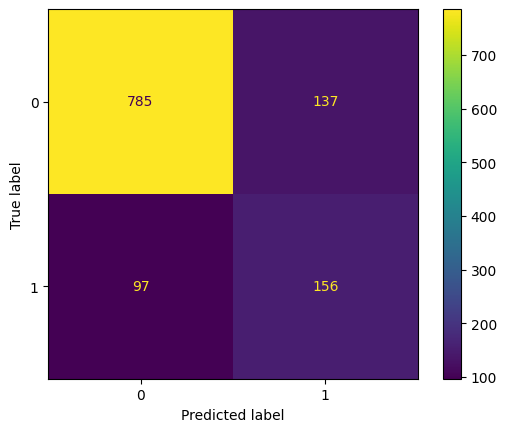

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc,y_test),display_labels=clf.classes_)
fig.plot()

#### Random forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=42)
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       882
           1       0.68      0.56      0.62       293

    accuracy                           0.83      1175
   macro avg       0.77      0.74      0.75      1175
weighted avg       0.82      0.83      0.82      1175

[[805  77]
 [128 165]]


In [70]:
#find the best tree value
error_rate = []

for i in range(1,40):
    rfc = RandomForestClassifier(n_estimators=i,criterion='entropy',random_state=42)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

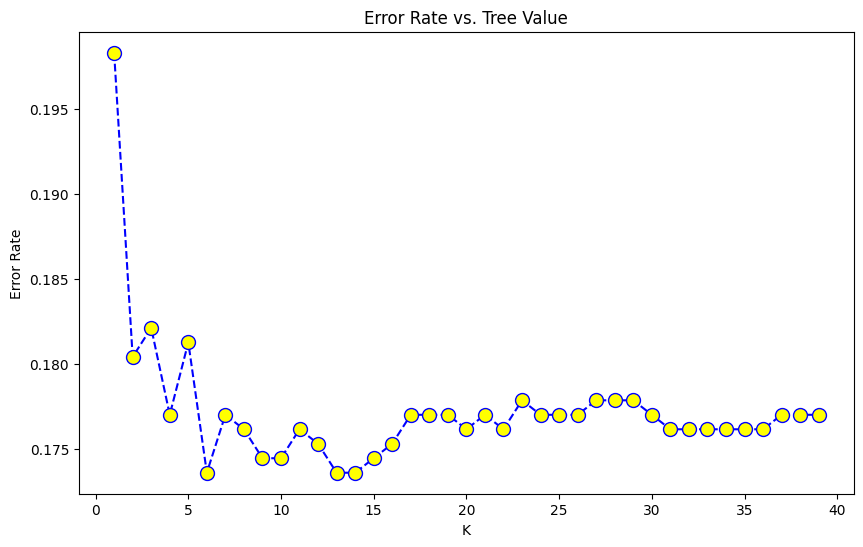

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. Tree Value')
plt.xlabel('K')
plt.ylabel('Error Rate') #error rate decrease as the tree value increases

In [72]:
rfc = RandomForestClassifier(n_estimators=5,criterion='entropy',random_state=42) #12- trees from elbow method
rfc.fit(X_train,y_train)
pred_rfc= rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       882
           1       0.66      0.57      0.61       293

    accuracy                           0.82      1175
   macro avg       0.76      0.74      0.75      1175
weighted avg       0.81      0.82      0.81      1175

[[794  88]
 [125 168]]


#### Xgboost classifier

In [73]:
from xgboost import XGBClassifier
classifier=XGBClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       882
           1       0.66      0.57      0.61       293

    accuracy                           0.82      1175
   macro avg       0.76      0.74      0.75      1175
weighted avg       0.81      0.82      0.81      1175

[[794  88]
 [125 168]]


In [74]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the XGBoost classifier
classifier = XGBClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_xgb = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_xgb))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       882
           1       0.71      0.52      0.60       293

    accuracy                           0.83      1175
   macro avg       0.78      0.73      0.75      1175
weighted avg       0.82      0.83      0.82      1175

Confusion Matrix:
[[820  62]
 [140 153]]
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


#### Catboost classifier

In [75]:
from catboost import CatBoostClassifier
classifier=CatBoostClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

Learning rate set to 0.019947
0:	learn: 0.6665090	total: 6ms	remaining: 6s
1:	learn: 0.6402623	total: 8.11ms	remaining: 4.04s
2:	learn: 0.6154404	total: 12.5ms	remaining: 4.17s
3:	learn: 0.5914645	total: 16.8ms	remaining: 4.19s
4:	learn: 0.5689979	total: 21.7ms	remaining: 4.31s
5:	learn: 0.5476173	total: 24.9ms	remaining: 4.13s
6:	learn: 0.5276220	total: 29.2ms	remaining: 4.13s
7:	learn: 0.5084383	total: 33.4ms	remaining: 4.14s
8:	learn: 0.4910751	total: 37.6ms	remaining: 4.13s
9:	learn: 0.4742011	total: 41.8ms	remaining: 4.14s
10:	learn: 0.4585415	total: 45.9ms	remaining: 4.13s
11:	learn: 0.4443680	total: 50.2ms	remaining: 4.13s
12:	learn: 0.4301438	total: 54.6ms	remaining: 4.15s
13:	learn: 0.4171924	total: 60.9ms	remaining: 4.29s
14:	learn: 0.4043824	total: 63.1ms	remaining: 4.14s
15:	learn: 0.3925335	total: 67.6ms	remaining: 4.16s
16:	learn: 0.3816665	total: 71.8ms	remaining: 4.15s
17:	learn: 0.3710584	total: 75.9ms	remaining: 4.14s
18:	learn: 0.3610386	total: 80ms	remaining: 4.13s


In [76]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the CatBoost classifier
classifier = CatBoostClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform grid search cross-validation with early stopping
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data with early stopping
grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=(X_test, y_test), verbose=False)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_catboost = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_catboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_catboost))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       882
           1       0.71      0.52      0.60       293

    accuracy                           0.83      1175
   macro avg       0.78      0.73      0.75      1175
weighted avg       0.82      0.83      0.82      1175

Confusion Matrix:
[[820  62]
 [140 153]]
Best Parameters: {'depth': 3, 'iterations': 100, 'learning_rate': 0.05}


### XLM_RoBERTa Ensemble models for kannada text

In [51]:
 #get the features vector and their labels (training set)
X_train,y_train=preprocess_dataset(train_df,
                                   model=xlm_model,
                                   training=True,
                                   batch_size=128)

Processing Data: 100%|██████████| 37/37 [01:23<00:00,  2.27s/it]


In [52]:
#get the features vector and their labels (testing set)
X_test,y_test=preprocess_dataset(test_df,
                                 model=xlm_model,
                                 training=False,
                                 batch_size=128)

Processing Data: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


#### SVM

In [53]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)
pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       882
           1       0.69      0.54      0.61       293

    accuracy                           0.82      1175
   macro avg       0.77      0.73      0.75      1175
weighted avg       0.82      0.82      0.82      1175

[[810  72]
 [134 159]]


#### Decision tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
clf=DecisionTreeClassifier(criterion='entropy',random_state=42)
clf.fit(X_train,y_train)
pred_dtc=clf.predict(X_test)
print(classification_report(pred_dtc,y_test))
print(confusion_matrix(pred_dtc,y_test))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       910
           1       0.54      0.60      0.57       265

    accuracy                           0.79      1175
   macro avg       0.71      0.72      0.72      1175
weighted avg       0.80      0.79      0.80      1175

[[775 135]
 [107 158]]


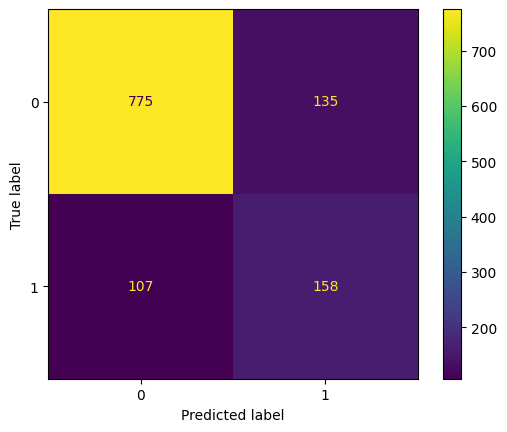

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc,y_test),display_labels=clf.classes_)
fig.plot()

#### Random forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=42)
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       882
           1       0.66      0.53      0.59       293

    accuracy                           0.82      1175
   macro avg       0.76      0.72      0.73      1175
weighted avg       0.81      0.82      0.81      1175

[[803  79]
 [138 155]]


In [57]:
#find the best tree value
error_rate = []

for i in range(1,40):
    rfc = RandomForestClassifier(n_estimators=i,criterion='entropy',random_state=42)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

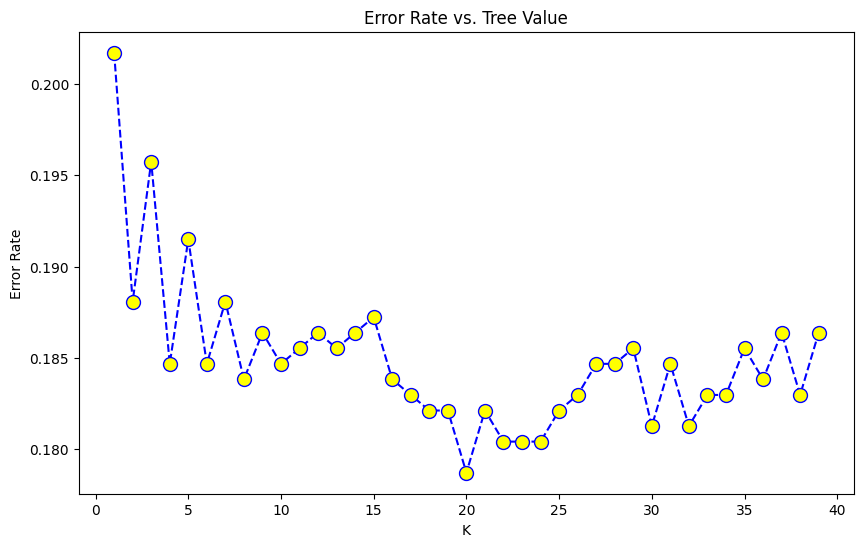

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. Tree Value')
plt.xlabel('K')
plt.ylabel('Error Rate') #error rate decrease as the tree value increases

In [59]:
rfc = RandomForestClassifier(n_estimators=5,criterion='entropy',random_state=42) #12- trees from elbow method
rfc.fit(X_train,y_train)
pred_rfc= rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       882
           1       0.63      0.55      0.59       293

    accuracy                           0.81      1175
   macro avg       0.75      0.72      0.73      1175
weighted avg       0.80      0.81      0.80      1175

[[789  93]
 [132 161]]


#### Xgboost classifier

In [60]:
from xgboost import XGBClassifier
classifier=XGBClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       882
           1       0.63      0.55      0.59       293

    accuracy                           0.81      1175
   macro avg       0.75      0.72      0.73      1175
weighted avg       0.80      0.81      0.80      1175

[[789  93]
 [132 161]]


In [61]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the XGBoost classifier
classifier = XGBClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_xgb = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_xgb))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       882
           1       0.66      0.56      0.61       293

    accuracy                           0.82      1175
   macro avg       0.76      0.73      0.75      1175
weighted avg       0.81      0.82      0.81      1175

Confusion Matrix:
[[799  83]
 [129 164]]
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


#### Catboost classifier

In [62]:
from catboost import CatBoostClassifier
classifier=CatBoostClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

Learning rate set to 0.019947
0:	learn: 0.6584481	total: 3ms	remaining: 3s
1:	learn: 0.6251870	total: 4.76ms	remaining: 2.38s
2:	learn: 0.5962702	total: 6.78ms	remaining: 2.25s
3:	learn: 0.5668947	total: 8.66ms	remaining: 2.15s
4:	learn: 0.5393360	total: 10.6ms	remaining: 2.11s
5:	learn: 0.5140276	total: 12.6ms	remaining: 2.09s
6:	learn: 0.4898224	total: 14.5ms	remaining: 2.06s
7:	learn: 0.4690874	total: 16.4ms	remaining: 2.03s
8:	learn: 0.4483523	total: 19.2ms	remaining: 2.11s
9:	learn: 0.4287044	total: 22.2ms	remaining: 2.19s
10:	learn: 0.4104176	total: 24ms	remaining: 2.15s
11:	learn: 0.3945580	total: 25.9ms	remaining: 2.13s
12:	learn: 0.3786725	total: 27.9ms	remaining: 2.12s
13:	learn: 0.3642021	total: 29.8ms	remaining: 2.1s
14:	learn: 0.3503395	total: 31.7ms	remaining: 2.08s
15:	learn: 0.3372915	total: 33.5ms	remaining: 2.06s
16:	learn: 0.3251680	total: 35.3ms	remaining: 2.04s
17:	learn: 0.3145650	total: 38ms	remaining: 2.08s
18:	learn: 0.3041894	total: 40ms	remaining: 2.06s
19:	l

In [63]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the CatBoost classifier
classifier = CatBoostClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform grid search cross-validation with early stopping
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data with early stopping
grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=(X_test, y_test), verbose=False)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_catboost = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_catboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_catboost))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       882
           1       0.66      0.57      0.61       293

    accuracy                           0.82      1175
   macro avg       0.76      0.74      0.75      1175
weighted avg       0.81      0.82      0.82      1175

Confusion Matrix:
[[798  84]
 [127 166]]
Best Parameters: {'depth': 3, 'iterations': 100, 'learning_rate': 0.1}


### DistilBERT Ensemble models for kannada text

In [38]:
 #get the features vector and their labels (training set)
X_train,y_train=preprocess_dataset(train_df,
                                   model=distilbert_model,
                                   training=True,
                                   batch_size=128)

Processing Data: 100%|██████████| 37/37 [00:48<00:00,  1.31s/it]


In [39]:
#get the features vector and their labels (testing set)
X_test,y_test=preprocess_dataset(test_df,
                                 model=distilbert_model,
                                 training=False,
                                 batch_size=128)

Processing Data: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


#### SVM

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)
pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       882
           1       0.65      0.58      0.61       293

    accuracy                           0.82      1175
   macro avg       0.76      0.74      0.75      1175
weighted avg       0.81      0.82      0.81      1175

[[791  91]
 [123 170]]


#### Decision tree

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
clf=DecisionTreeClassifier(criterion='entropy',random_state=42)
clf.fit(X_train,y_train)
pred_dtc=clf.predict(X_test)
print(classification_report(pred_dtc,y_test))
print(confusion_matrix(pred_dtc,y_test))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       873
           1       0.59      0.58      0.58       302

    accuracy                           0.79      1175
   macro avg       0.72      0.72      0.72      1175
weighted avg       0.79      0.79      0.79      1175

[[754 119]
 [128 174]]


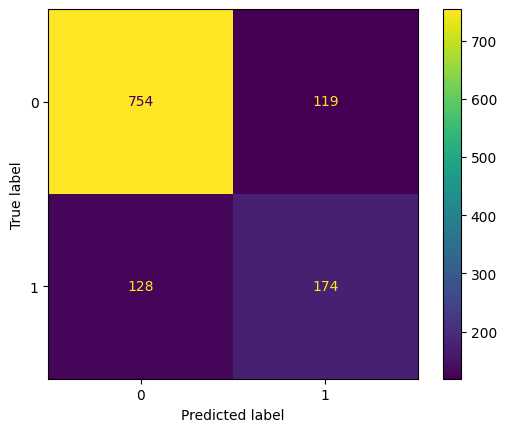

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc,y_test),display_labels=clf.classes_)
fig.plot()

#### Random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=42)
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       882
           1       0.62      0.58      0.60       293

    accuracy                           0.81      1175
   macro avg       0.74      0.73      0.74      1175
weighted avg       0.80      0.81      0.81      1175

[[780 102]
 [124 169]]


In [44]:
#find the best tree value
error_rate = []

for i in range(1,40):
    rfc = RandomForestClassifier(n_estimators=i,criterion='entropy',random_state=42)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

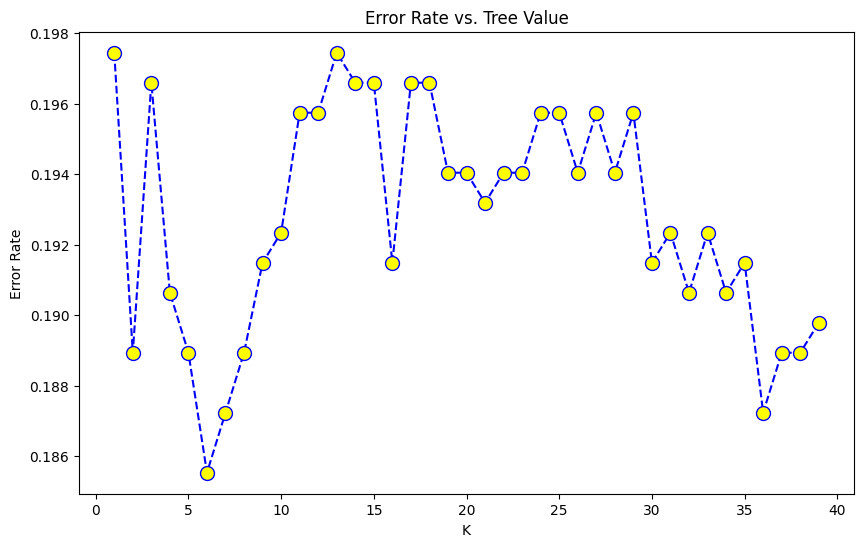

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. Tree Value')
plt.xlabel('K')
plt.ylabel('Error Rate') #error rate decrease as the tree value increases

In [46]:
rfc = RandomForestClassifier(n_estimators=5,criterion='entropy',random_state=42) #12- trees from elbow method
rfc.fit(X_train,y_train)
pred_rfc= rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       882
           1       0.63      0.59      0.61       293

    accuracy                           0.81      1175
   macro avg       0.75      0.74      0.74      1175
weighted avg       0.81      0.81      0.81      1175

[[780 102]
 [120 173]]


#### Xgboost classifier

In [47]:
from xgboost import XGBClassifier
classifier=XGBClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       882
           1       0.63      0.59      0.61       293

    accuracy                           0.81      1175
   macro avg       0.75      0.74      0.74      1175
weighted avg       0.81      0.81      0.81      1175

[[780 102]
 [120 173]]


In [48]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the XGBoost classifier
classifier = XGBClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_xgb = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_xgb))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       882
           1       0.65      0.58      0.61       293

    accuracy                           0.82      1175
   macro avg       0.76      0.74      0.75      1175
weighted avg       0.81      0.82      0.81      1175

Confusion Matrix:
[[792  90]
 [124 169]]
Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


#### Catboost classifier

In [49]:
from catboost import CatBoostClassifier
classifier=CatBoostClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

Learning rate set to 0.019947
0:	learn: 0.6602057	total: 2.32ms	remaining: 2.32s
1:	learn: 0.6291066	total: 4.23ms	remaining: 2.11s
2:	learn: 0.6004229	total: 5.97ms	remaining: 1.98s
3:	learn: 0.5728207	total: 8ms	remaining: 1.99s
4:	learn: 0.5491617	total: 9.96ms	remaining: 1.98s
5:	learn: 0.5245098	total: 11.5ms	remaining: 1.91s
6:	learn: 0.5013101	total: 13.4ms	remaining: 1.9s
7:	learn: 0.4806741	total: 15.3ms	remaining: 1.9s
8:	learn: 0.4607259	total: 17.5ms	remaining: 1.93s
9:	learn: 0.4422331	total: 19.7ms	remaining: 1.95s
10:	learn: 0.4249200	total: 24.6ms	remaining: 2.21s
11:	learn: 0.4089097	total: 26.3ms	remaining: 2.16s
12:	learn: 0.3940084	total: 28.2ms	remaining: 2.14s
13:	learn: 0.3791306	total: 30ms	remaining: 2.11s
14:	learn: 0.3653757	total: 31.8ms	remaining: 2.09s
15:	learn: 0.3526287	total: 33.7ms	remaining: 2.07s
16:	learn: 0.3412330	total: 35.3ms	remaining: 2.04s
17:	learn: 0.3296016	total: 37.2ms	remaining: 2.03s
18:	learn: 0.3190122	total: 39ms	remaining: 2.02s
1

In [50]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the CatBoost classifier
classifier = CatBoostClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform grid search cross-validation with early stopping
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data with early stopping
grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=(X_test, y_test), verbose=False)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_catboost = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_catboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_catboost))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       882
           1       0.64      0.59      0.62       293

    accuracy                           0.82      1175
   macro avg       0.76      0.74      0.75      1175
weighted avg       0.81      0.82      0.81      1175

Confusion Matrix:
[[785  97]
 [119 174]]
Best Parameters: {'depth': 3, 'iterations': 100, 'learning_rate': 0.1}


### mBERT Ensemble models for kannada text

In [25]:
 #get the features vector and their labels (training set)
X_train,y_train=preprocess_dataset(train_df,
                                   model=mbert_model,
                                   training=True,
                                   batch_size=128)

Processing Data: 100%|██████████| 37/37 [00:42<00:00,  1.16s/it]


In [26]:
#get the features vector and their labels (testing set)
X_test,y_test=preprocess_dataset(test_df,
                                 model=mbert_model,
                                 training=False,
                                 batch_size=128)

Processing Data: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


#### SVM

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)
pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       882
           1       0.72      0.54      0.61       293

    accuracy                           0.83      1175
   macro avg       0.79      0.73      0.75      1175
weighted avg       0.82      0.83      0.82      1175

[[820  62]
 [136 157]]


#### Decision tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
clf=DecisionTreeClassifier(criterion='entropy',random_state=42)
clf.fit(X_train,y_train)
pred_dtc=clf.predict(X_test)
print(classification_report(pred_dtc,y_test))
print(confusion_matrix(pred_dtc,y_test))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       944
           1       0.51      0.64      0.56       231

    accuracy                           0.81      1175
   macro avg       0.71      0.74      0.72      1175
weighted avg       0.83      0.81      0.81      1175

[[799 145]
 [ 83 148]]


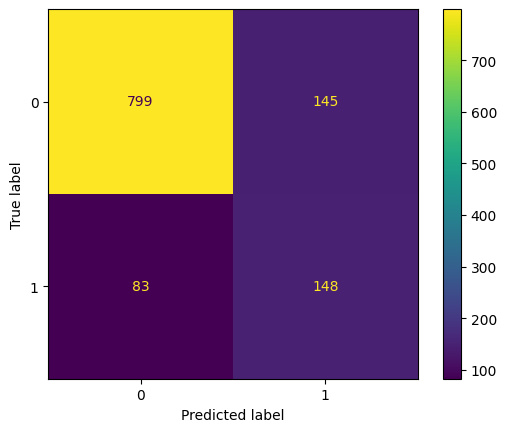

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc,y_test),display_labels=clf.classes_)
fig.plot()

#### Random forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=42)
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       882
           1       0.69      0.52      0.59       293

    accuracy                           0.82      1175
   macro avg       0.77      0.72      0.74      1175
weighted avg       0.81      0.82      0.81      1175

[[813  69]
 [142 151]]


In [31]:
#find the best tree value
error_rate = []

for i in range(1,40):
    rfc = RandomForestClassifier(n_estimators=i,criterion='entropy',random_state=42)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

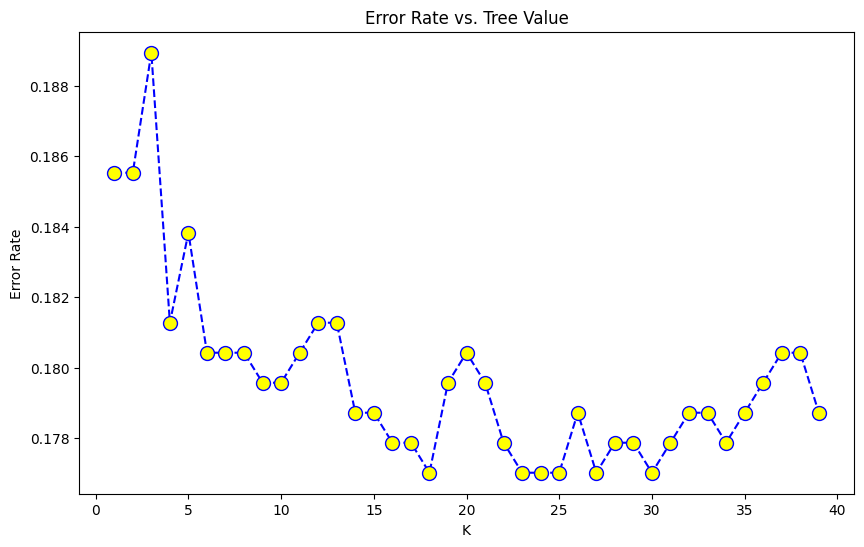

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. Tree Value')
plt.xlabel('K')
plt.ylabel('Error Rate') #error rate decrease as the tree value increases

In [33]:
rfc = RandomForestClassifier(n_estimators=5,criterion='entropy',random_state=42) #12- trees from elbow method
rfc.fit(X_train,y_train)
pred_rfc= rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       882
           1       0.67      0.51      0.58       293

    accuracy                           0.82      1175
   macro avg       0.76      0.71      0.73      1175
weighted avg       0.81      0.82      0.81      1175

[[810  72]
 [144 149]]


#### Xgboost classifier

In [34]:
from xgboost import XGBClassifier
classifier=XGBClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       882
           1       0.67      0.51      0.58       293

    accuracy                           0.82      1175
   macro avg       0.76      0.71      0.73      1175
weighted avg       0.81      0.82      0.81      1175

[[810  72]
 [144 149]]


In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the XGBoost classifier
classifier = XGBClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_xgb = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_xgb))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       882
           1       0.71      0.51      0.59       293

    accuracy                           0.83      1175
   macro avg       0.78      0.72      0.74      1175
weighted avg       0.82      0.83      0.82      1175

Confusion Matrix:
[[823  59]
 [145 148]]
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


#### Catboost classifier

In [36]:
from catboost import CatBoostClassifier
classifier=CatBoostClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

Learning rate set to 0.019947
0:	learn: 0.6562919	total: 2.34ms	remaining: 2.33s
1:	learn: 0.6208793	total: 4.26ms	remaining: 2.13s
2:	learn: 0.5884160	total: 6.37ms	remaining: 2.12s
3:	learn: 0.5581837	total: 8.34ms	remaining: 2.08s
4:	learn: 0.5296996	total: 10.4ms	remaining: 2.07s
5:	learn: 0.5000535	total: 12.3ms	remaining: 2.04s
6:	learn: 0.4735936	total: 14.3ms	remaining: 2.03s
7:	learn: 0.4512304	total: 16.2ms	remaining: 2.01s
8:	learn: 0.4286911	total: 18.1ms	remaining: 1.99s
9:	learn: 0.4082634	total: 20ms	remaining: 1.98s
10:	learn: 0.3885658	total: 21.9ms	remaining: 1.97s
11:	learn: 0.3698164	total: 23.9ms	remaining: 1.96s
12:	learn: 0.3529937	total: 26ms	remaining: 1.98s
13:	learn: 0.3369068	total: 28ms	remaining: 1.97s
14:	learn: 0.3211445	total: 30ms	remaining: 1.97s
15:	learn: 0.3065120	total: 32.1ms	remaining: 1.97s
16:	learn: 0.2933999	total: 33.9ms	remaining: 1.96s
17:	learn: 0.2822211	total: 36ms	remaining: 1.96s
18:	learn: 0.2713174	total: 37.9ms	remaining: 1.96s
19

In [37]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the CatBoost classifier
classifier = CatBoostClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform grid search cross-validation with early stopping
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data with early stopping
grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=(X_test, y_test), verbose=False)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_catboost = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_catboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_catboost))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       882
           1       0.71      0.54      0.61       293

    accuracy                           0.83      1175
   macro avg       0.78      0.73      0.75      1175
weighted avg       0.82      0.83      0.82      1175

Confusion Matrix:
[[816  66]
 [135 158]]
Best Parameters: {'depth': 5, 'iterations': 200, 'learning_rate': 0.05}


### Muril Ensemble models for kannada text

In [12]:
 #get the features vector and their labels (training set)
X_train,y_train=preprocess_dataset(train_df,
                                   model=muril_model,
                                   training=True,
                                   batch_size=128)

Processing Data: 100%|██████████| 37/37 [00:48<00:00,  1.31s/it]


In [13]:
#get the features vector and their labels (testing set)
X_test,y_test=preprocess_dataset(test_df,
                                 model=muril_model,
                                 training=False,
                                 batch_size=128)

Processing Data: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


#### SVM

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)
pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       882
           1       0.67      0.59      0.63       293

    accuracy                           0.83      1175
   macro avg       0.77      0.75      0.76      1175
weighted avg       0.82      0.83      0.82      1175

[[799  83]
 [121 172]]


#### Decision tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
clf=DecisionTreeClassifier(criterion='entropy',random_state=42)
clf.fit(X_train,y_train)
pred_dtc=clf.predict(X_test)
print(classification_report(pred_dtc,y_test))
print(confusion_matrix(pred_dtc,y_test))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       897
           1       0.58      0.61      0.59       278

    accuracy                           0.80      1175
   macro avg       0.73      0.73      0.73      1175
weighted avg       0.81      0.80      0.80      1175

[[773 124]
 [109 169]]


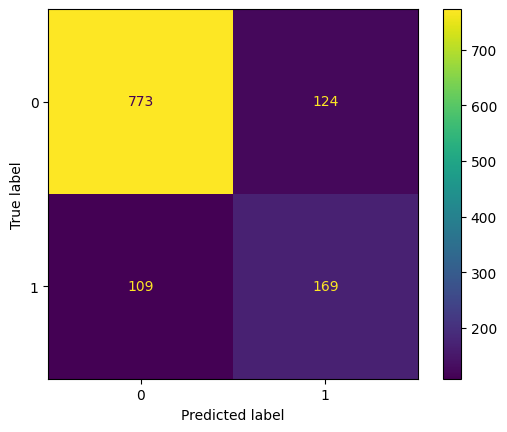

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(pred_dtc,y_test),display_labels=clf.classes_)
fig.plot()

#### Random forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=42)
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       882
           1       0.65      0.58      0.61       293

    accuracy                           0.82      1175
   macro avg       0.76      0.74      0.75      1175
weighted avg       0.81      0.82      0.81      1175

[[791  91]
 [123 170]]


In [18]:
#find the best tree value
error_rate = []

for i in range(1,40):
    rfc = RandomForestClassifier(n_estimators=i,criterion='entropy',random_state=42)
    rfc.fit(X_train,y_train)
    pred_i = rfc.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

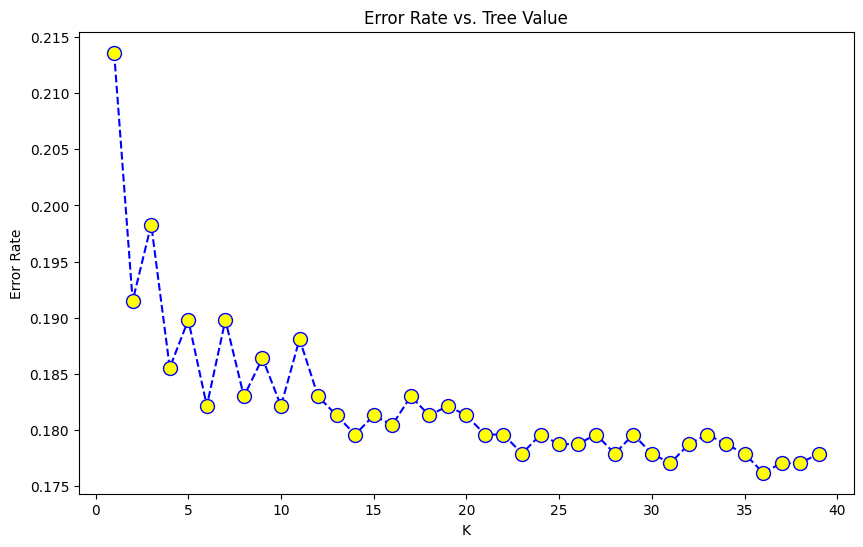

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. Tree Value')
plt.xlabel('K')
plt.ylabel('Error Rate') #error rate decrease as the tree value increases

In [20]:
rfc = RandomForestClassifier(n_estimators=5,criterion='entropy',random_state=42) #12- trees from elbow method
rfc.fit(X_train,y_train)
pred_rfc= rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       882
           1       0.63      0.59      0.61       293

    accuracy                           0.81      1175
   macro avg       0.75      0.74      0.74      1175
weighted avg       0.81      0.81      0.81      1175

[[779 103]
 [120 173]]


#### Xgboost classifier

In [21]:
from xgboost import XGBClassifier
classifier=XGBClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       882
           1       0.63      0.59      0.61       293

    accuracy                           0.81      1175
   macro avg       0.75      0.74      0.74      1175
weighted avg       0.81      0.81      0.81      1175

[[779 103]
 [120 173]]


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define the XGBoost classifier
classifier = XGBClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_xgb = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_xgb))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       882
           1       0.67      0.61      0.64       293

    accuracy                           0.83      1175
   macro avg       0.77      0.75      0.76      1175
weighted avg       0.82      0.83      0.83      1175

Confusion Matrix:
[[795  87]
 [115 178]]
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


#### Catboost classifier

In [23]:
from catboost import CatBoostClassifier
classifier=CatBoostClassifier()
classifier.fit(X_train,y_train)
pred_xgb= classifier.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

Learning rate set to 0.019947
0:	learn: 0.6679507	total: 52ms	remaining: 52s
1:	learn: 0.6433973	total: 54ms	remaining: 26.9s
2:	learn: 0.6201251	total: 55.9ms	remaining: 18.6s
3:	learn: 0.5980579	total: 57.7ms	remaining: 14.4s
4:	learn: 0.5777709	total: 59.5ms	remaining: 11.8s
5:	learn: 0.5588491	total: 61.2ms	remaining: 10.1s
6:	learn: 0.5405577	total: 63ms	remaining: 8.94s
7:	learn: 0.5231756	total: 64.9ms	remaining: 8.05s
8:	learn: 0.5067705	total: 66.6ms	remaining: 7.34s
9:	learn: 0.4911792	total: 68.6ms	remaining: 6.79s
10:	learn: 0.4764854	total: 70.4ms	remaining: 6.33s
11:	learn: 0.4627032	total: 72.4ms	remaining: 5.96s
12:	learn: 0.4495720	total: 73.9ms	remaining: 5.61s
13:	learn: 0.4373936	total: 75.7ms	remaining: 5.33s
14:	learn: 0.4255807	total: 77.7ms	remaining: 5.1s
15:	learn: 0.4143451	total: 79.6ms	remaining: 4.9s
16:	learn: 0.4039233	total: 81.4ms	remaining: 4.71s
17:	learn: 0.3940429	total: 83.2ms	remaining: 4.54s
18:	learn: 0.3848323	total: 85.1ms	remaining: 4.39s
19

In [24]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the CatBoost classifier
classifier = CatBoostClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform grid search cross-validation with early stopping
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data with early stopping
grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=(X_test, y_test), verbose=False)

# Get the best model
best_classifier = grid_search.best_estimator_

# Make predictions with the best model
pred_catboost = best_classifier.predict(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, pred_catboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_catboost))

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       882
           1       0.67      0.61      0.64       293

    accuracy                           0.83      1175
   macro avg       0.77      0.75      0.76      1175
weighted avg       0.82      0.83      0.83      1175

Confusion Matrix:
[[795  87]
 [115 178]]
Best Parameters: {'depth': 3, 'iterations': 200, 'learning_rate': 0.05}


In [77]:
import pickle
with open('kannada_catboost_classifier.sav', 'wb') as f:
    pickle.dump(best_classifier, f)

In [78]:
import shutil

local_model_path = '/content/sample_data/kannada_catboost_classifier.sav'
destination_path = '/content/drive/MyDrive/Capstone/Models/Kannada/kannada_catboost_classifier.sav'

# Copy the file to the destination directory
shutil.copy(local_model_path, destination_path)


'/content/drive/MyDrive/Capstone/Models/Kannada/kannada_catboost_classifier.sav'